In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import io
import regex
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from scipy import sparse

# Upload Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CayJoBla/EmotionRecognition/master/data/original_data.csv', index_col=0)

In [3]:
tweet_data = df.copy()
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 1956967341 to 1753919049
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  40000 non-null  object
 1   content    40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB


## Consolidate and encode classes

In [4]:
# Original classes
np.sort(pd.unique(tweet_data['sentiment']))

array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry'], dtype=object)

In [5]:
# New classes
tweet_data.loc[tweet_data["sentiment"]=="empty", "sentiment"] = "sadness"
tweet_data.loc[tweet_data["sentiment"]=="boredom", "sentiment"] = "neutral"
tweet_data.loc[tweet_data["sentiment"]=="hate", "sentiment"] = "anger"
tweet_data.loc[tweet_data["sentiment"]=="fun", "sentiment"] = "enthusiasm"
np.sort(pd.unique(tweet_data['sentiment']))

array(['anger', 'enthusiasm', 'happiness', 'love', 'neutral', 'relief',
       'sadness', 'surprise', 'worry'], dtype=object)

In [6]:
# Encode
tweet_data["sentiment"] = tweet_data["sentiment"].astype('category').cat.codes

## Clean and organize tweet text

In [7]:
# Define identifiers
urls = r"http:[^\s]+|w{3}\.[^\s]+|[\w]+\.[\w]{3}[/\w]*"
users = r"@(\w){1,}"
tags = r"#(\w){1,}"
symbols = r"[&[\w]+;|~$/%/^/&/*-/+/=/\/|///?:;\"<>,]|[.]+"
words = r"[\w]+"

# Parse unique identifiers
tweet_data['num_urls'] = tweet_data['content'].apply(lambda text: len(regex.findall(urls, text.lower()))).values
tweet_data['content_parsed'] = tweet_data['content'].apply(lambda text: regex.sub(urls, "", text)).values
tweet_data['num_pings'] = tweet_data['content_parsed'].apply(lambda text: len(regex.findall(users, text.lower()))).values
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: regex.sub(users, "", text)).values
tweet_data['num_tags'] = tweet_data['content_parsed'].apply(lambda text: len(regex.findall(tags, text.lower()))).values
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: regex.sub(tags, "", text)).values
tweet_data['#!'] = tweet_data['content_parsed'].str.count('!')
tweet_data['#?'] = tweet_data['content_parsed'].str.count('\\?')
tweet_data['#...'] = tweet_data['content_parsed'].str.count('\\.{2,}')
tweet_data['Upper/Lower ratio'] = (tweet_data['content_parsed'].str.findall(r'[A-Z]').str.len()+1) / (tweet_data['content_parsed'].str.findall(r'[a-z]').str.len()+1)
tweet_data['Number of Words'] = tweet_data['content_parsed'].apply(lambda n: len(n.split()))
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: text.replace(';', '; '))
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: text.replace('&', ' &'))
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: text.replace('_', ' '))
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: text.replace('ï', ''))
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: text.replace('½', ''))
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: regex.sub(symbols, " ", text)).values
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: regex.sub(r"'", "", text)).values
tweet_data['words'] = tweet_data['content_parsed'].apply(lambda text: regex.findall(words, text.lower())).values
tweet_data["avg word length"] = tweet_data['words'].apply(lambda word_array: np.mean([len(word) for word in word_array]))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


### Data Analysis

1 14374 15.661168361884368
[31 26  1 ...  1  1  1]


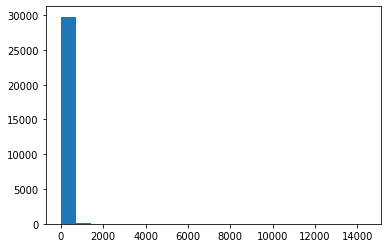

In [8]:
#tweet_data = tweet_data.drop(columns=['content_parsed'])
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweet_data["content_parsed"].values)

total_counts = np.sum(X, axis=0)
print(np.min(total_counts), np.max(total_counts), np.mean(total_counts))
print(np.array(total_counts)[0])
counts = np.array(total_counts)[0]
plt.hist(counts, bins=20)
plt.show()

In [ ]:
plt.hist(counts[counts >= 5], bins=20)

In [ ]:
temp = np.array(total_counts)[0]
names = vectorizer.get_feature_names_out()
print(temp)
print(names[-20:])
print(names[temp >= 5])
for i in range(20):
    ind = np.argmin(temp)
    print(names[ind], temp[ind])
    mask = temp != temp[ind]
    temp = temp[mask]
    names = names[mask]
plt.hist(temp[temp >= 5], bins=20)

### Remove columns with too many or too few counts

In [9]:
X = vectorizer.fit_transform(tweet_data["content_parsed"].values)
X = sparse.csc_matrix(X)
print(X.shape)

counts = np.array(total_counts)[0]
names = vectorizer.get_feature_names_out()

print(names[counts > 7000])
X = X[:,counts <= 7000]         # Drop too many
X = X[:,counts >= 5]            # Drop too few
names = names[counts >= 5]


(40000, 29888)
['and' 'my' 'the' 'to' 'you']


### Format Data

In [10]:
# Convert to sparse matrix
tweet_data = tweet_data.drop(columns=["words","content_parsed","content"])
data = sparse.hstack((tweet_data.values, X), format='csr')

In [11]:
# Move labels to the opposite side
data = sparse.hstack((data[:, 1:], data[:, :1]), format='csr')

In [12]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 1956967341 to 1753919049
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentiment          40000 non-null  int8   
 1   num_urls           40000 non-null  int64  
 2   num_pings          40000 non-null  int64  
 3   num_tags           40000 non-null  int64  
 4   #!                 40000 non-null  int64  
 5   #?                 40000 non-null  int64  
 6   #...               40000 non-null  int64  
 7   Upper/Lower ratio  40000 non-null  float64
 8   Number of Words    40000 non-null  int64  
 9   avg word length    39899 non-null  float64
dtypes: float64(2), int64(7), int8(1)
memory usage: 3.1 MB


In [13]:
print(data.shape)
sparse.save_npz("cleaned_data.npz", data)

(40000, 5776)


In [14]:
tweet_data

,sentiment,num_urls,num_pings,num_tags,#!,#?,#...,Upper/Lower ratio,Number of Words,avg word length
tweet_id,,,,,,,,,,
1956967341,6,0,1,0,0,0,0,0.016129,17,3.812500
1956967666,6,0,0,0,0,0,2,0.045455,10,4.000000
1956967696,6,0,0,0,0,0,2,0.074074,3,6.750000
1956967789,1,0,0,0,1,0,0,0.192308,7,4.142857
1956968416,4,0,1,0,0,0,0,0.054545,14,4.000000
...,...,...,...,...,...,...,...,...,...,...
1753918954,4,0,1,0,0,0,0,1.000000,0,NaN
1753919001,3,0,0,0,0,0,0,0.238095,6,4.000000
1753919005,3,0,0,0,1,0,0,0.043956,25,3.720000


In [15]:
tweet_data.to_csv("cleaned_data.csv")